*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow,numpy

Sebastian Raschka 

CPython 3.6.1
IPython 6.1.0

tensorflow 1.1.0
numpy 1.12.1


# Using Queue Runners to Feed Images Directly from Disk

TensorFlow provides users with multiple options for providing data to the model. One of the probably most common methods is to define placeholders in the TensorFlow graph and feed the data from the current Python session into the TensorFlow `Session` using the `feed_dict` parameter. Using this approach, a large dataset that does not fit into memory is most conveniently and efficiently stored using NumPy archives as explained in [Chunking an Image Dataset for Minibatch Training using NumPy NPZ Archives](image-data-chunking-npz.ipynb) or HDF5 data base files ([Storing an Image Dataset for Minibatch Training using HDF5](image-data-chunking-hdf5.ipynb)).

Another approach, which is often preferred when it comes to computational efficiency, is to do the "data loading" directly in the graph using input queues from so-called TFRecords files, which is illustrated in the [Using Input Pipelines to Read Data from TFRecords Files](tfrecords.ipynb) notebook. 

This notebook will introduce an alternative approach which is similar to the TFRecords approach as we will be using input queues to load the data directly on the graph. However, here we are going to read the images directly from JPEG files, which is a useful approach if disk space is a concern and we don't want to create a large TFRecords file from our "large" image database.

Beyond the examples in this notebook, you are encouraged to read more in TensorFlow's "[Reading Data](https://www.tensorflow.org/programmers_guide/reading_data)" guide.

## 0. The Dataset

Let's pretend we have a directory of images containing two subdirectories with images for training, validation, and testing. The following function will create such a dataset of images in JPEG format locally for demonstration purposes.

In [2]:
# Note that executing the following code 
# cell will download the MNIST dataset
# and save all the 60,000 images as separate JPEG
# files. This might take a few minutes depending
# on your machine.

import numpy as np
from helper import mnist_export_to_jpg

np.random.seed(123)
mnist_export_to_jpg(path='./')

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


The `mnist_export_to_jpg` function called above creates 3 directories, mnist_train, mnist_test, and mnist_validation. Note that the names of the subdirectories correspond directly to the class label of the images that are stored under it:

In [3]:
import os

for i in ('train', 'valid', 'test'): 
    dirs = [d for d in os.listdir('mnist_%s' % i) if not d.startswith('.')]
    print('mnist_%s subdirectories' % i, dirs)

mnist_train subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_valid subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_test subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


To make sure that the images look okay, the snippet below plots an example image from the subdirectory `mnist_train/9/`:

(28, 28)


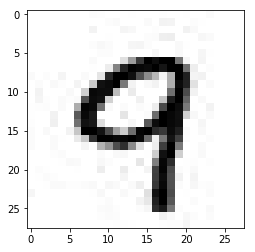

In [4]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

some_img = os.path.join('./mnist_train/9/', os.listdir('./mnist_train/9/')[0])

img = mpimg.imread(some_img)
print(img.shape)
plt.imshow(img, cmap='binary');

Note: The JPEG format introduces a few artifacts that we can see in the image above. In this case, we use JPEG instead of PNG. Here, JPEG is used for demonstration purposes since that's still format many image datasets are stored in.

# 1. Reading

This section provides an example of how to use the [`tf.WholeFileReader`](https://www.tensorflow.org/api_docs/python/tf/WholeFileReader) and a filename queue to read in the images from the `mnist_train` directory. Also, we will be extracting the class labels directly from the file paths and convert the images to a one-hot encoded format that we will use in the later sections to train a multilayer neural network.

In [5]:
import tensorflow as tf


g = tf.Graph()
with g.as_default():
    
    filename_queue = tf.train.string_input_producer(
        tf.train.match_filenames_once('mnist_train/*/*.jpg'),
        seed=123,
        shuffle=True)

    image_reader = tf.WholeFileReader()

    file_name, image_raw = image_reader.read(filename_queue)
    file_name = tf.identity(file_name, name='file_name')
    image = tf.image.decode_jpeg(image_raw, name='image')
    image = tf.cast(image, tf.float32)
    label = tf.string_split([file_name], '/').values[1]
    label = tf.string_to_number(label, tf.int32, name='label')
    onehot_label = tf.one_hot(indices=label, 
                              depth=10, 
                              name='onehot_label')

    

with tf.Session(graph=g) as sess:

    sess.run(tf.local_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,
                                           coord=coord)
    
    image_tensor, file_name, class_label, ohe_label =\
            sess.run(['image:0', 
                      'file_name:0', 
                      'label:0',
                      'onehot_label:0'])

    print('Image shape:', image_tensor.shape)
    print('File name:', file_name)    
    print('Class label:', class_label)  
    print('One-hot class label:', ohe_label)  

    coord.request_stop()
    coord.join(threads)

Image shape: (28, 28, 1)
File name: b'mnist_train/6/22340.jpg'
Class label: 6
One-hot class label: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


- The `tf.train.string_input_producer` produces a filename queue that we iterate over in the session. Note that we need to call `sess.run(tf.local_variables_initializer())` for our filename queue. y." 

- The `tf.train.start_queue_runners` function uses a queue runner that uses a separate thread to load the filenames from the `queue` that we defined in the graph without blocking the reader.

Note that it is important to shuffle the dataset so that we can later make use of TensorFlow's [`tf.train.shuffle_batch`](https://www.tensorflow.org/api_docs/python/tf/train/shuffle_batch) function and don't need to load the whole dataset into memory to shuffle epochs.

## 2. Reading in batches

While the previous section illustrated how we can use input pipelines to read images one by one, we rarely (want to) train neural networks with one datapoint at a time but use minibatches instead. TensorFlow also has some really convenient utility functions to do the batching conveniently. In the following code example, we will use the [`tf.train.shuffle_batch`](https://www.tensorflow.org/api_docs/python/tf/train/shuffle_batch) function to load the images and labels in batches of size 64.

Also, let us put the code for processing the images and labels into a function, `read_images_from_disk`, that we can reuse later.

In [6]:
import tensorflow as tf


def read_images_from_disk(filename_queue, image_dimensions, normalize=True):

    image_reader = tf.WholeFileReader()
    file_name, image_raw = image_reader.read(filename_queue)
    file_name = tf.identity(file_name, name='file_name')
    image = tf.image.decode_jpeg(image_raw, name='image')
    image.set_shape(image_dimensions)
    image = tf.cast(image, tf.float32)

    if normalize:
        # normalize to [0, 1] range
        image = image / 255.
        
    label = tf.string_split([file_name], '/').values[1]
    label = tf.string_to_number(label, tf.int32)
    onehot_label = tf.one_hot(indices=label,
                              depth=10, 
                              name='onehot_label')
    return image, onehot_label
    
    
    

g = tf.Graph()
with g.as_default():
    

    filename_queue = tf.train.string_input_producer(
            tf.train.match_filenames_once('mnist_train/*/*.jpg'),
            seed=123)
     
    image, label = read_images_from_disk(filename_queue,
                                         image_dimensions=[28, 28, 1])
    
    
    image_batch, label_batch = tf.train.shuffle_batch([image, label], 
                                                       batch_size=64,
                                                       capacity=2000,
                                                       min_after_dequeue=1000,
                                                       num_threads=1,
                                                       seed=123)


    
with tf.Session(graph=g) as sess:

    sess.run(tf.local_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,
                                           coord=coord)
    
    multipe_images, multiple_labels = sess.run([image_batch, label_batch])
    print('Image batch shape:', multipe_images.shape)
    print('Label batch shape:', label_batch.shape)

    coord.request_stop()
    coord.join(threads)

Image batch shape: (64, 28, 28, 1)
Label batch shape: (64, 10)


The other relevant arguments we provided to `tf.train.shuffle_batch` are described below:

- `capacity`: An integer that defines the maximum number of elements in the queue.
- `min_after_dequeue`: The minimum number elements in the queue after a dequeue, which is used to ensure that a minimum number of data points have been loaded for shuffling.
- `num_threads`: The number of threads for enqueuing.

## 3. Use queue runners to train a neural network

In this section, we will take the concepts that were introduced in the previous sections and train a multilayer perceptron using the concepts introduced in the previous sections: the `read_images_from_disk` function, a filename queue, and the `tf.train.shuffle_batch` function.
                                  

In [7]:
##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.1
batch_size = 128
n_epochs = 15
n_iter = n_epochs * (45000 // batch_size)

# Architecture
n_hidden_1 = 128
n_hidden_2 = 256
height, width = 28, 28
n_classes = 10



##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(123)

    # Input data
    filename_queue = tf.train.string_input_producer(
            tf.train.match_filenames_once('mnist_train/*/*.jpg'),
            seed=123)
     
    image, label = read_images_from_disk(filename_queue,
                                         image_dimensions=[28, 28, 1])
    image = tf.reshape(image, (width*height,))
    
    
    image_batch, label_batch = tf.train.shuffle_batch([image, label], 
                                                       batch_size=batch_size,
                                                       capacity=2000,
                                                       min_after_dequeue=1000,
                                                       num_threads=1,
                                                       seed=123)
    
    tf_images = tf.placeholder_with_default(image_batch,
                                            shape=[None, 784], 
                                            name='images')
    tf_labels = tf.placeholder_with_default(label_batch, 
                                            shape=[None, 10], 
                                            name='labels')

    # Model parameters
    weights = {
        'h1': tf.Variable(tf.truncated_normal([height*width, n_hidden_1], stddev=0.1)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_images, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss and optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=tf_labels)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Prediction
    prediction = tf.argmax(out_layer, 1, name='prediction')
    correct_prediction = tf.equal(tf.argmax(label_batch, 1), tf.argmax(out_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    saver0 = tf.train.Saver()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    avg_cost = 0.
    iter_per_epoch = n_iter // n_epochs
    epoch = 0

    for i in range(n_iter):
        _, cost = sess.run(['train', 'cost:0'])
        avg_cost += cost
        
        if not i % iter_per_epoch:
            epoch += 1
            avg_cost /= iter_per_epoch
            print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost))
            avg_cost = 0.
            
        
    coord.request_stop()
    coord.join(threads)
    
    saver0.save(sess, save_path='./mlp')

Epoch: 001 | AvgCost: 0.007
Epoch: 002 | AvgCost: 0.481
Epoch: 003 | AvgCost: 0.234
Epoch: 004 | AvgCost: 0.180
Epoch: 005 | AvgCost: 0.147
Epoch: 006 | AvgCost: 0.125
Epoch: 007 | AvgCost: 0.108
Epoch: 008 | AvgCost: 0.094
Epoch: 009 | AvgCost: 0.084
Epoch: 010 | AvgCost: 0.075
Epoch: 011 | AvgCost: 0.067
Epoch: 012 | AvgCost: 0.061
Epoch: 013 | AvgCost: 0.055
Epoch: 014 | AvgCost: 0.049
Epoch: 015 | AvgCost: 0.046


After looking at the graph above, you probably wondered why we used [`tf.placeholder_with_default`](https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default) to define the two placeholders:

```python
tf_images = tf.placeholder_with_default(image_batch,
                                            shape=[None, 784], 
                                            name='images')
tf_labels = tf.placeholder_with_default(label_batch, 
                                        shape=[None, 10], 
                                        name='labels')
```      

In the training session above, these placeholders are being ignored if we don't feed them via a session's `feed_dict`, or in other words "[A `tf.placeholder_with_default` is a] placeholder op that passes through input when its output is not fed" (https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default).

However, these placeholders are useful if we want to feed new data to the graph and make predictions after training as in a real-world application, which we will see in the next section.

## 4. Feeding new datapoints through placeholders

To demonstrate how we can feed new data points to the network that are not part of the training queue, let's use the test dataset and load the images into Python and pass it to the graph using a `feed_dict`:

In [8]:
import matplotlib.image as mpimg
import numpy as np
import glob


img_paths = np.array([p for p in glob.iglob('mnist_test/*/*.jpg')])
labels = np.array([int(path.split('/')[1]) for path in img_paths])


with tf.Session() as sess:
    
    saver1 = tf.train.import_meta_graph('./mlp.meta')
    saver1.restore(sess, save_path='./mlp')
    
    num_correct = 0
    cnt = 0
    for path, lab in zip(img_paths, labels):
        cnt += 1
        image = mpimg.imread(path)
        image = image.reshape(1, -1)
        
        pred = sess.run('prediction:0', 
                         feed_dict={'images:0': image})

        num_correct += int(lab == pred[0])
    acc = num_correct / cnt * 100

print('Test accuracy: %.1f%%' % acc)

INFO:tensorflow:Restoring parameters from ./mlp
Test accuracy: 97.1%
